
# Exploring and Manipulating Linear Classifier Templates

This project will teach you how to create a linear classifier using visual templates. You will:

1. **Load and preprocess a combined weights image** containing all 10 weights (0-9)
2. **Convert the image into a weight matrix** for a linear classifier
3. **Test the classifier on MNIST dataset** and achieve >20% accuracy


**Important**: 
You need to provide your own combined weights image named <span style="color: red;">all_weights_combined_(YOUR CUID).png</span> in the Project 1 folder. 
This image should contain all 10 weight templates stacked vertically, with each template being approximately 28x28 pixels when resized.

**Weight template Generator**:
You can use this temporary website to generate and download your image:  
[https://nianyi-li.github.io/CPSC-6430-fall25/P1_GUI/](https://nianyi-li.github.io/CPSC-6430-fall25/P1_GUI/)

After downloading, rename your file as instructed, <span style="color: red;">all_weights_combined_(YOUR CUID).png</span>, and place it in the Project 1 folder.

***NOTE:***
When filling in the code, please REMOVE the `pass` statement.
DO NOT remove the TODO coding highlight in your submission.


### <span style="color: red;"> Grading Criteria:</span>

- Test accuracy must be >20% (60% points)
- Code quality and implementation (8% points)
- Analysis and answers to questions (32% points)
- **Total: 5 points (50% of project score)**



In [13]:
# # Google Colab Setup (Comment out for local computer running)
################################################################################
# Uncomment and set the path to your project folder in Google Drive
################################################################################
# from google.colab import drive
# drive.mount('/content/drive')

# FOLDERNAME = 'cpsc8430/assignments/project1/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.

# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
# %cd /content/drive/My\ Drive/$FOLDERNAME

In [14]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

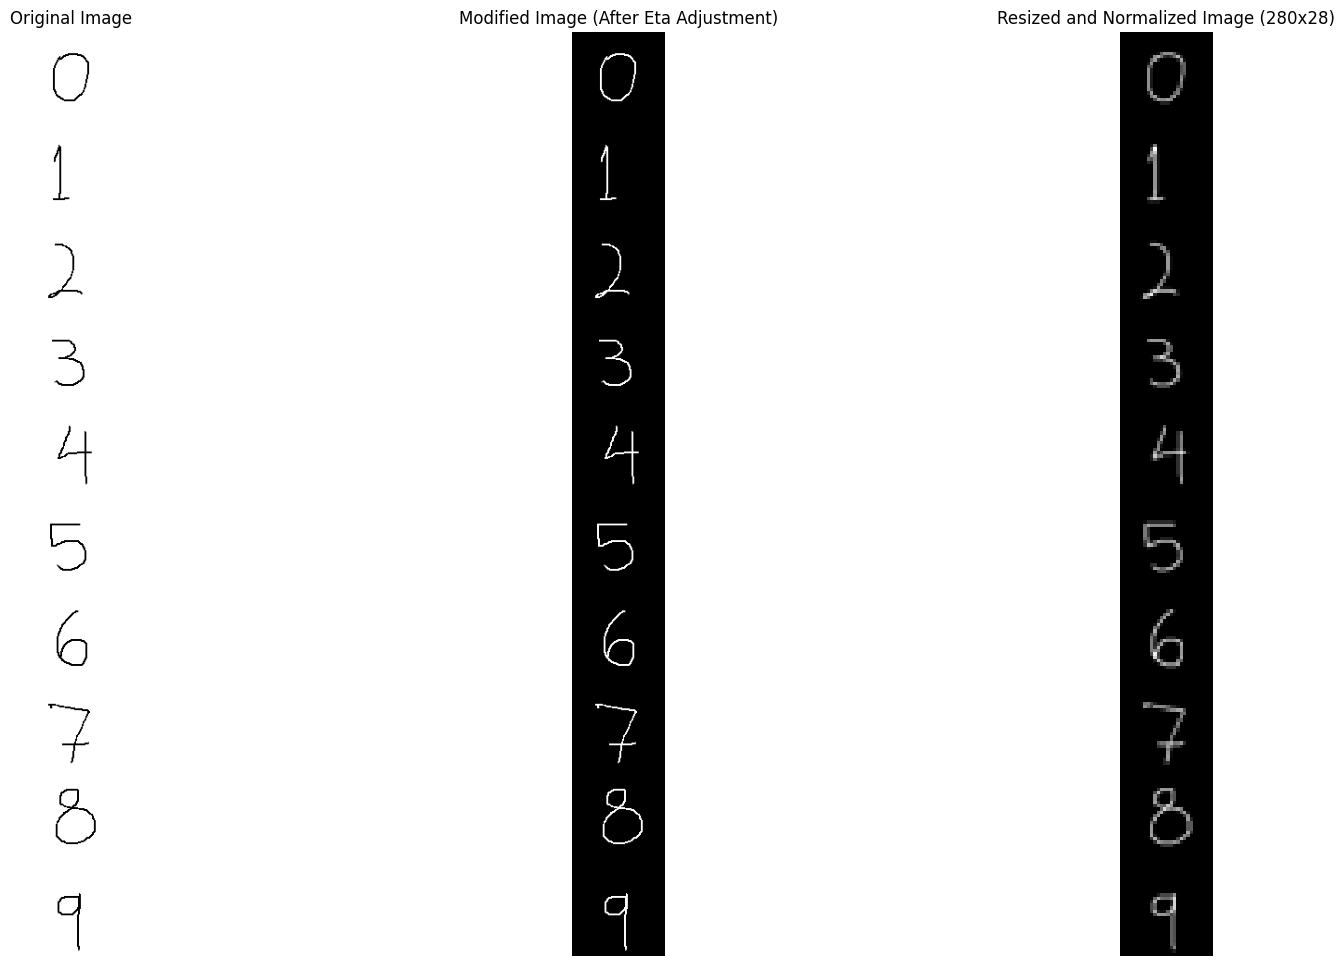

Normalized image tensor shape: torch.Size([280, 28])
Value range: [-1.00, 1.00]


In [15]:
# Load and preprocess the combined digits image
image_path = 'all_weights_combined_szinn.png' # all_digits_combined_4
img = Image.open(image_path)
img_array = np.array(img)

# Convert to grayscale if image is RGB, White is 255, Black is 0
if len(img_array.shape) == 3:
    img_array = img_array.mean(axis=2)


################################################################################
# TODO: Try different eta values to control the grayscale inversion of the image.
# eta = 0.0 -> original image, eta = 1.0 -> fully inverted (255 - img_array), eta = 0.5 -> halfway

eta = 1  # Change this value between 0.0 and 1.0 to experiment
img_modified = (1 - eta) * img_array + eta * (255 - img_array)
################################################################################

# Resize to height 280 and width 28 (10 blocks of 28x28 stacked vertically)
target_size = (28, 280)  # Note: PIL uses (width, height)
img_resized = Image.fromarray(img_modified.astype(np.uint8)).resize(target_size)
img_tensor = torch.tensor(np.array(img_resized), dtype=torch.float32)

# Normalize to [-1, 1]
img_min = img_tensor.min()
img_max = img_tensor.max()
img_normalized = 2.0 * (img_tensor - img_min) / (img_max - img_min) - 1.0

# Display original, modified, and resized images
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_modified, cmap='gray')
plt.title('Modified Image (After Eta Adjustment)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_normalized.numpy(), cmap='gray')
plt.title('Resized and Normalized Image (280x28)')
plt.tight_layout()
plt.axis('off')
plt.show()

print(f"Normalized image tensor shape: {img_normalized.shape}")
print(f"Value range: [{img_normalized.min():.2f}, {img_normalized.max():.2f}]")

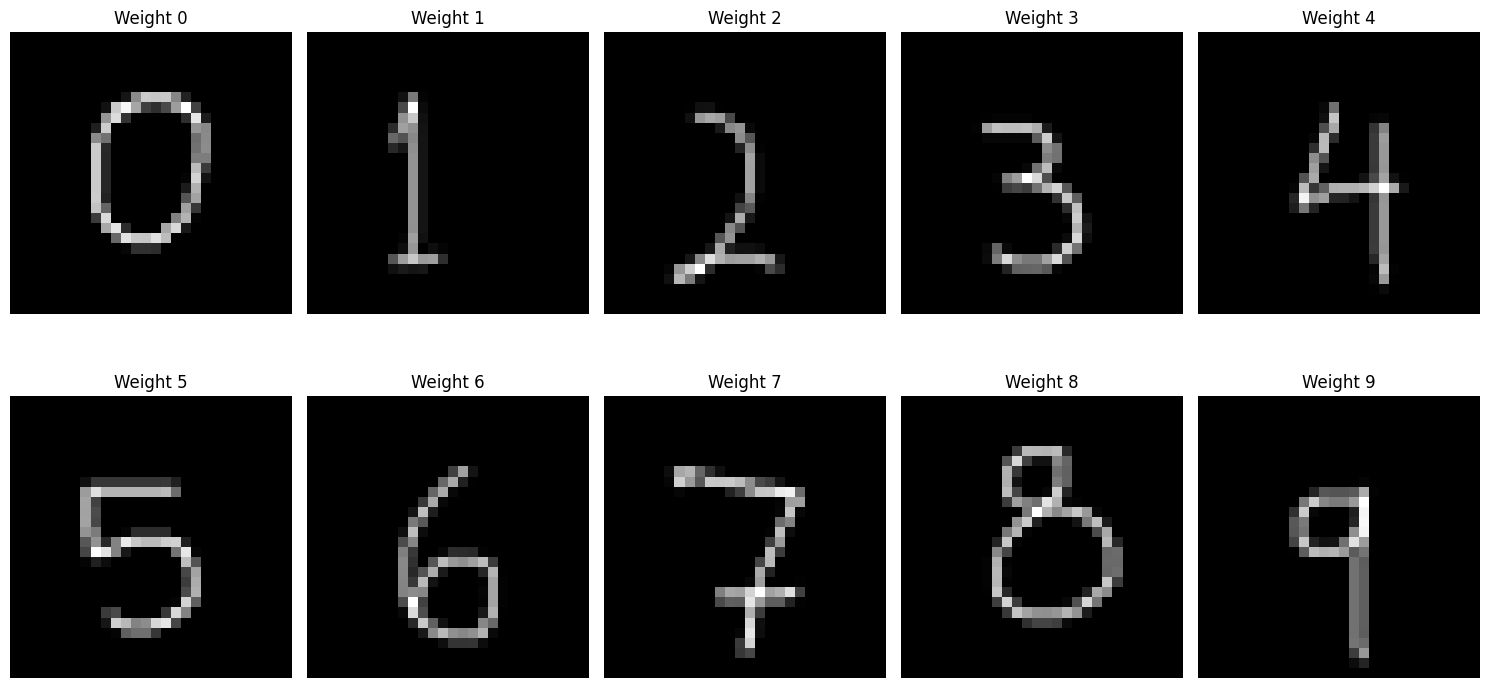

Weight matrix shape: torch.Size([10, 784])


In [16]:
# Create weight matrix [10, 784] from the normalized image
weight_matrix = torch.zeros(10, 784)

# The image is 280x28, which means we have 10 blocks of 28x28 stacked vertically
for i in range(10):
    # Extract the i-th 28x28 block (vertically stacked)
    start_row = i * 28
    end_row = start_row + 28
    block = img_normalized[start_row:end_row, :]
    
    # Flatten the block and assign to the corresponding row in weight matrix
    weight_matrix[i] = block.flatten()

# Visualize each weight as a 28x28 image
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weight_matrix[i].reshape(28, 28), cmap='gray')
    plt.title(f'Weight {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Weight matrix shape: {weight_matrix.shape}")

Weight matrix visualization complete!
Matrix statistics:
  Min value: -1.000
  Max value: 1.000
  Mean value: -0.935
  Std value: 0.244


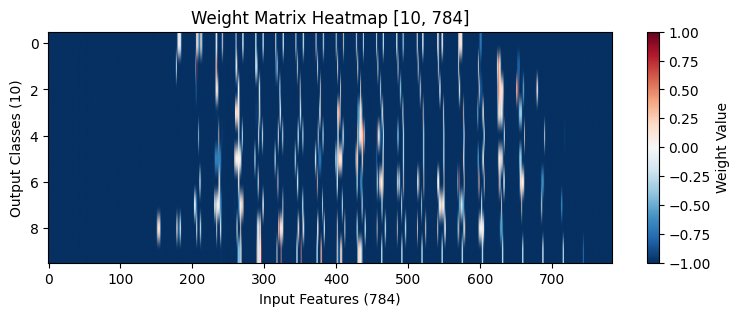

In [17]:
# Visualize the large weight matrix [10, 784]
plt.figure(figsize=(20, 3))

# Create a heatmap of the entire weight matrix
plt.subplot(1, 2, 1)
weight_heatmap = plt.imshow(weight_matrix.numpy(), cmap='RdBu_r', aspect='auto')
plt.colorbar(weight_heatmap, label='Weight Value')
plt.title('Weight Matrix Heatmap [10, 784]')
plt.xlabel('Input Features (784)')
plt.ylabel('Output Classes (10)')


print("Weight matrix visualization complete!")
print(f"Matrix statistics:")
print(f"  Min value: {weight_matrix.min():.3f}")
print(f"  Max value: {weight_matrix.max():.3f}")
print(f"  Mean value: {weight_matrix.mean():.3f}")
print(f"  Std value: {weight_matrix.std():.3f}")

In [ ]:
# Load MNIST test dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

test_dataset = torchvision.datasets.MNIST(
    root='cpsc8430/datasets/MNIST',
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False
)

# Create random bias
bias = torch.randn(10)

# Evaluation function
def evaluate():
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten the images
            images = images.view(-1, 784)
            
            # Forward pass: compute scores
            scores = torch.mm(images, weight_matrix.t()) + bias
            
            # Get predictions
            _, predicted = torch.max(scores, 1)
            
            # Update statistics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

# Test the classifier
accuracy = evaluate()
print(f"Test Accuracy: {accuracy:.2f}%")

# IMPORTANT: This accuracy should be greater than 20% for full credit
# assert accuracy > 20.0, f"Test accuracy {accuracy:.2f}% is below the required threshold of 20%"
# print(f"✅ Test accuracy {accuracy:.2f}% meets the requirement of >20%!")

# Store the result for grading
test_accuracy_result = accuracy

Test Accuracy: 23.61%


## Inline Questions

### Question 1
Try adjusting the value of `eta` (located in the second code cell after "TODO") to each of the following values: {0, 0.25, 0.5, 0.75, 1}. For each value, run the code and report the resulting test accuracy. What do you observe as you change `eta`? Why do you think this happens?

$\color{blue}{\textit{Your Answer:}}$

- Testing accuracy for $\eta=0$: 9.62%
- Testing accuracy for $\eta=0.25$: 9.63%
- Testing accuracy for $\eta=0.5$: 9.80%
- Testing accuracy for $\eta=0.75$: 22.84%
- Testing accuracy for $\eta=1$: 23.04%

As eta changes, so does the background and digit color through grayscale inversion. At `eta = 0`, the digits and their background are unchanged in color, while `eta = 1` is a complete inversion. The testing accuracy also changes, going from `9.62%` at `eta = 0` to `23.04%` at `eta = 1`. This probably happens because the weights change with the grayscale.


### Question 2
Why do you think this approach achieves an accuracy above 20%? What are the advantages and limitations of using visual templates as weights?

$\color{blue}{	\textit{Your Answer:}}$

I think it achieves an accuracy above `20%` because the weights minimize the loss at this level of inversion. 
| Advantages | Disadvantages |
| ---------- | ------------- |
| Weights are likely closer to what is expected as they follow the basic outlines of the training and test data set | By using visual templates, you limit the ability to change the weights for better predictions as they are fixed on the given template.|
| | If any digit is written weird, the model can't identify the digit |


### Question 3
How could you improve the performance of this classifier? What modifications would you make to achieve higher accuracy?

$\color{blue}{	\textit{Your Answer:}}$

I would change the weight matrix so it isn't dependent on the visual templates and instead use gradient descent to improve the weights. I would play around with other hyperparameters such as batch size and bias.

### Question 4
What does the weight matrix represent in this linear classifier? How does it relate to the original combined digits image?

$\color{blue}{	\textit{Your Answer:}}$

The weight matrix is the combined digit input I gave. By decomposing the image, you can see the individual digits.




